### OCI Data Science - ML Pipelines sample notebook with ADS - with custom conda environment

This sample notebook demonstrates how to use Oracle ADS libfary to create an ML **pipeline** with 3 steps:
 * the first step sets a paramter for the next step
 * the second step creates a data table with the number of rows defined in the first step. generated data is random. the data table is then saved to object storage and the name and location of the data is saved as a parameter for the next step.
 * the third step reads the location of the data and then the data table from the previous step.
 
Note: the notebook creates the pipeline and runs it. The code itself for the steps is located in the 3 zip files mlpipelin_step1,2,3

In [1]:
from random import randrange

import oci
import ads
import os
from os import environ

from ads.catalog.project import ProjectCatalog

# ADS for pipelines
from ads.pipeline.ads_pipeline_step import PipelineStep
from ads.pipeline.ads_pipeline import Pipeline
from ads.pipeline import CustomScriptStep
from ads.jobs import ScriptRuntime

In [2]:
# make sure you are using ADS version 2.8 or above
print(ads.__version__)

2.8.5


In [3]:
if 'NB_SESSION_COMPARTMENT_OCID' in os.environ:
    # using the notebook's compartment if running on OCI Data Science Notebook Session
    compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']
else:
    # set the compartment OCID if you are working locally
    compartment_id = '<YOUR_COMPARTMENT_OCID>'

In [4]:
# this will work whether working on a local machine (using API key) or in OCI Notebook Session (using Resource Principal)
if "OCI_RESOURCE_PRINCIPAL_VERSION" in os.environ:
    # Use resource principal
    print("using Resource Principal for auth")
    ads.set_auth(auth="resource_principal")
else:
    # Use api_key with config file
    print("using API key for auth")
    ads.set_auth(auth="api_key")    

using Resource Principal for auth


In [5]:
# global settings

project_id = "ocid1.datascienceproject.oc1.eu-frankfurt-1.amaaaaaangencdyarxbilkubzgqjom3vpr4ejxpp6xtw3blfdvuyhd6sggta"
log_group_id = "ocid1.loggroup.oc1.eu-frankfurt-1.amaaaaaangencdyazs4l4rzrzsarlej6mqlwlbz6bmnx4adwdlssveam2jaa"

pipeline_name = f"ads_pipeline_sample_prc"

## create a new pipeline with ADS

In [6]:
#
# Infrastructure: in this case we use the same VM shape for all the 3 steps...
# but, in general, we would have different shapes. Simply define them and use.
#

NAMESPACE = "frqap2zhtzbe"
CONDA_BUCKET = "procco-envs"

CUSTOM_ENV_URI = f"oci://{CONDA_BUCKET}@{NAMESPACE}/conda_environments/gpu/prc_pytorch_gpu_/1.0/prc_pytorch_gpu_v1_0"

SHAPE_NAME = "VM.Standard2.4"
STORAGE_SIZE = 100
SERVICE_CONDA_NAME = "onnx110_p37_cpu_v1"

INFRASTRUCTURE = (
    CustomScriptStep()
    .with_block_storage_size(STORAGE_SIZE)
    .with_shape_name(SHAPE_NAME)
)

step_one = (
    PipelineStep("step1")
    .with_description("Pass data by value")
    .with_infrastructure(INFRASTRUCTURE)
    .with_runtime(
        ScriptRuntime()
        .with_source("mlpipeline_step1.zip")
        # .with_service_conda(SERVICE_CONDA_NAME)
        .with_custom_conda(CUSTOM_ENV_URI)
        .with_environment_variable(
            PIPELINE_STEP_RUN_ENTRYPOINT="mlpipeline_step1.py"
        )
    )
)

# for step 2 and 3 we need the servuce conda otherwise it fails !
step_two = (
    PipelineStep("step2")
    .with_description("pass data by reference")
    .with_infrastructure(INFRASTRUCTURE)
    .with_runtime(
        ScriptRuntime()
        .with_source("mlpipeline_step2.zip")
        .with_service_conda(SERVICE_CONDA_NAME)
        # .with_custom_conda(CUSTOM_ENV_URI)
        .with_environment_variable(
            PIPELINE_STEP_RUN_ENTRYPOINT="mlpipeline_step2.py"
        )
    )
)

step_three = (
    PipelineStep("step3")
    .with_description("read data by reference")
    .with_infrastructure(INFRASTRUCTURE)
    .with_runtime(
        ScriptRuntime()
        .with_source("mlpipeline_step3.zip")
        .with_service_conda(SERVICE_CONDA_NAME)
        # .with_custom_conda(CUSTOM_ENV_URI)
        .with_environment_variable(
            PIPELINE_STEP_RUN_ENTRYPOINT="mlpipeline_step3.py"
        )
    )
)

#### Here we define the DAG

In [7]:
pipeline = (
    Pipeline(pipeline_name)
    .with_compartment_id(compartment_id)
    .with_project_id(project_id)
    .with_log_group_id(log_group_id)  # if you define the LogGroupID but not the LogID, logs will be created automatically in the specified LogGroup
    .with_step_details([step_one, step_two, step_three])
    .with_dag(["step1 >> step2 >> step3"])                                                     
) # Use () to define multiple step dependencies, like (step1, step2) >> step3 to run step1 and step2 in parallel and step3 when they both finish

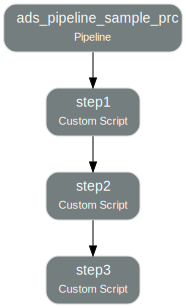

In [8]:
# view the pipeline graph visually, make sure you have the step dependencies defined correctly before creating the pipeline
pipeline.show()

In [9]:
#create the pipeline in the OCI Data Science service. ADS will take care of uploading all the artifacts 
pipeline.create()


kind: pipeline
spec:
  compartmentId: ocid1.compartment.oc1..aaaaaaaag2cpni5qj6li5ny6ehuahhepbpveopobooayqfeudqygdtfe6h3a
  dag:
  - step1 >> step2 >> step3
  displayName: ads_pipeline_sample_prc
  id: ocid1.datasciencepipeline.oc1.eu-frankfurt-1.amaaaaaangencdyaoafpm4yva775ffulaiwo5phiyyswzhpqo6u2glf54vla
  logGroupId: ocid1.loggroup.oc1.eu-frankfurt-1.amaaaaaangencdyazs4l4rzrzsarlej6mqlwlbz6bmnx4adwdlssveam2jaa
  projectId: ocid1.datascienceproject.oc1.eu-frankfurt-1.amaaaaaangencdyarxbilkubzgqjom3vpr4ejxpp6xtw3blfdvuyhd6sggta
  stepDetails:
  - kind: customScript
    spec:
      description: Pass data by value
      infrastructure:
        kind: infrastructure
        spec:
          blockStorageSize: 100
          shapeName: VM.Standard2.4
      name: step1
      runtime:
        kind: runtime
        spec:
          conda:
            type: published
            uri: oci://procco-envs@frqap2zhtzbe/conda_environments/gpu/prc_pytorch_gpu_/1.0/prc_pytorch_gpu_v1_0
          env:
   

In [10]:
# you can export the pipeline to a YAML file and later import it back
# pipeline.to_yaml("my_pipeline.yaml")

## Run the pipeline

In [11]:
pipeline_run_name = f"pipeline-run-prc01"

In [12]:
# uncomment the next line and set to the OCI Object Storage location to use for passing data. Make sure you have proper permissions.
data_location = "oci://procco-data@frqap2zhtzbe/"  # use: 'oci://<bucket>@<workspace>/'

In [13]:
# create the pipeline run
pipeline_run = pipeline.run(
    configuration_override_details = {
    "type": "DEFAULT",
    "environment_variables": {"DATA_LOCATION": data_location}
    }
)

In [14]:
print(pipeline_run.status)

ACCEPTED


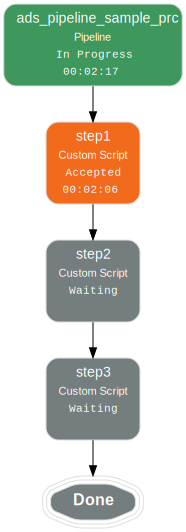

In [ ]:
# View the pipeline run graph with status of each step
pipeline_run.show(wait=True)

# you can keep watching the status updates using the following command
#pipeline_run.show(wait=True)

## view logs

In [ ]:
pipeline_run.watch() # by default it watches custom logs for all steps
#pipeline_run.watch("step1","step2") # watches custom logs for "step1" and "step2"

## View the pipeline run form the OCI console UI

In [ ]:
print("Ctrl-Click the hyperlink to open the pipeline run page in the OCI console UI")
print("https://cloud.oracle.com/data-science/pipeline-runs/{}".format(pipeline_run.id))

## Delete the pipeline

In [ ]:
#delete the pipeline when done
pipeline.delete(delete_related_pipeline_runs=True, delete_related_job_runs=True)  # delete also all the pipeline runs and job runs in the pipeline, otherwise those have to be deleted before deleting the pipeline